# Time Series Analysis & Forecasting on Microsoft Stock

## Import Libraries

In [1]:
import yfinance
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

## Load and inspect data

In [2]:
stock = yfinance.download('MSFT', start=dt.datetime(2025, 1, 1))
stock.head()

/tmp/ipython-input-3812197097.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yfinance.download('MSFT', start=dt.datetime(2025, 1, 1))
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT
Date,,,,,
2025-01-02,415.514832,422.950005,411.812165,422.413951,16896500
2025-01-03,420.249939,420.924952,416.467841,417.996542,16662900
2025-01-06,424.716980,431.139603,422.364340,424.865876,20573600
2025-01-07,419.277069,427.496435,417.718559,425.858524,18139100
2025-01-08,421.451019,423.843375,418.453145,420.359068,15054600


In [3]:
stock.columns = ["_".join(col) for col in stock.columns]
stock = stock.reset_index()
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         270 non-null    datetime64[ns]
 1   Close_MSFT   270 non-null    float64       
 2   High_MSFT    270 non-null    float64       
 3   Low_MSFT     270 non-null    float64       
 4   Open_MSFT    270 non-null    float64       
 5   Volume_MSFT  270 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 12.8 KB


Closing of the stock is considered as it may have lesser influence from external factors like microsoft public event, news, etc.

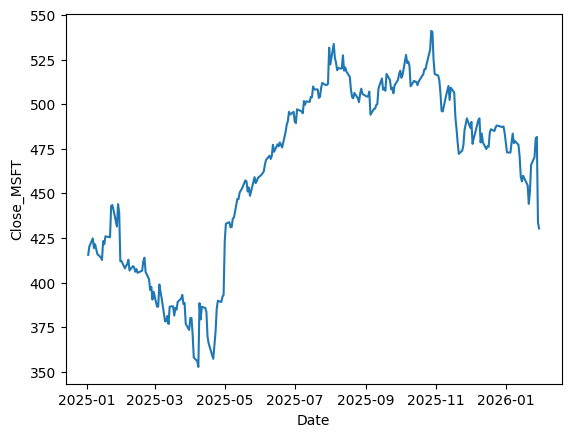

In [4]:
sns.lineplot(data=stock, x='Date', y='Close_MSFT');